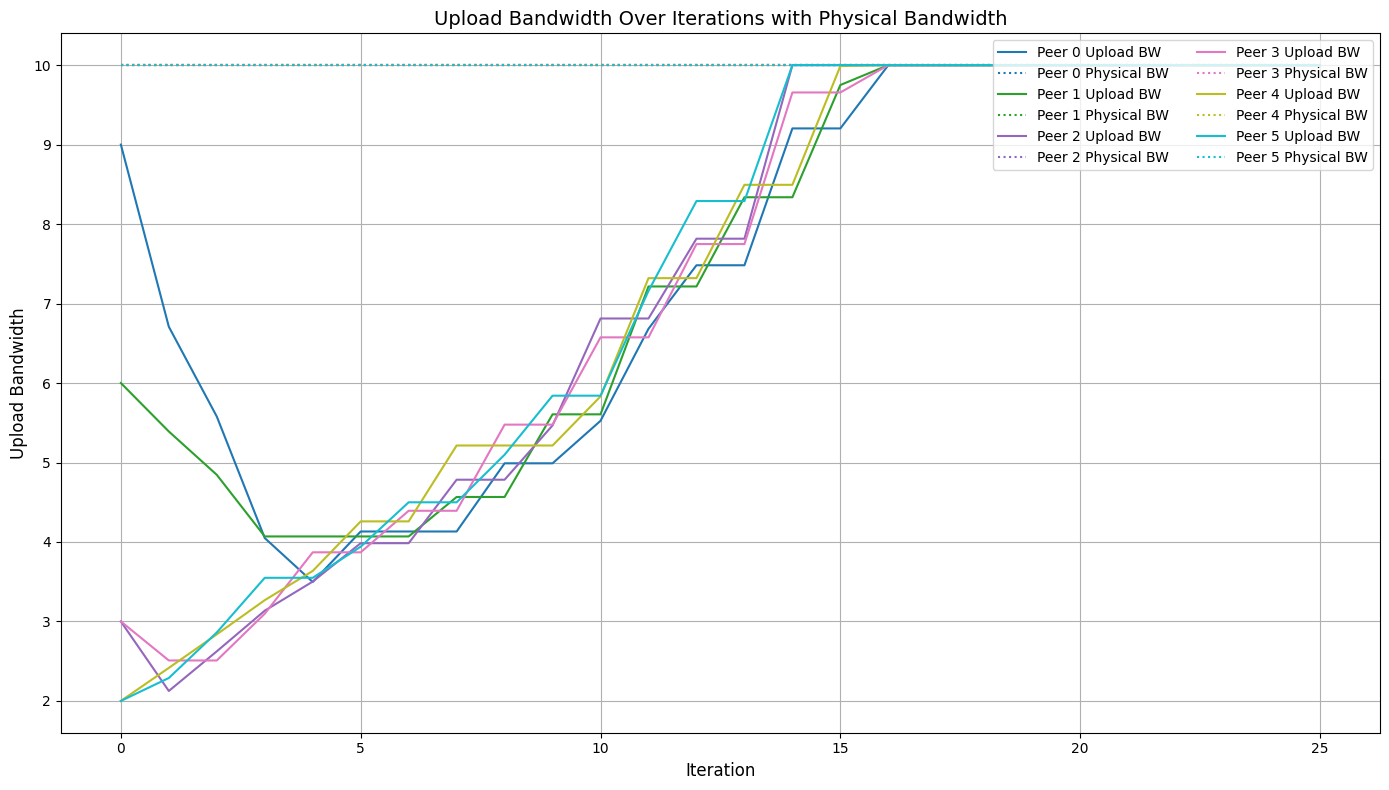

In [1]:
import numpy as np
from dataclasses import dataclass
from typing import List, Dict
from collections import defaultdict
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

@dataclass
class Peer:
    id: int
    physical_bandwidth: float
    upload_bandwidth: float
    group_id: int
    download_rate: float = 0.0

    def utility(self) -> float:
        return self.download_rate - self.upload_bandwidth

class BitTorrentNetwork:
    def __init__(self, n_upload_slots: int = 4, epsilon: float = 1.0, seed : int = None):
        if n_upload_slots < 1:
            raise ValueError("Number of upload slots must be at least 1.")
        self.n_u = n_upload_slots
        self.epsilon = epsilon
        self.peers: List[Peer] = []
        self.groups: Dict[int, List[Peer]] = {}
        
        if seed is not None : 
            np.random.seed(seed)
                
        
    def add_peer(self, physical_bandwidth: float, upload_bandwidth: float, group_id: int = -1):
        peer = Peer(
            id=len(self.peers),
            physical_bandwidth=physical_bandwidth,
            upload_bandwidth=upload_bandwidth,
            group_id=group_id
        )
        self.peers.append(peer)
        
    def _select_upload_targets(self, peer: Peer) -> List[int]:
        """Select top n_u peers to upload to based on upload_bandwidth."""
        # Exclude self and sort peers by upload_bandwidth descending, then by id ascending
        potential_targets = sorted(
            [p for p in self.peers if p.id != peer.id],
            key=lambda p: (-p.upload_bandwidth, p.id)
        )
        # Select top n_u peers to upload to
        upload_targets = [p.id for p in potential_targets[:self.n_u]]
        return upload_targets
    
    def _determine_uploaders(self, target_id: int) -> List[int]:
        """Determine which peers are uploading to the target peer."""
        uploaders = []
        for peer in self.peers:
            upload_targets = self._select_upload_targets(peer)
            if target_id in upload_targets:
                uploaders.append(peer.id)
        return uploaders
    
    def calculate_download_rates(self):
        """Calculate download rates for all peers."""
        # Dictionary to hold uploaders for each peer
        uploaders_dict = defaultdict(list)
        
        # Determine uploaders for each peer
        for peer in self.peers:
            upload_targets = self._select_upload_targets(peer)
            for target_id in upload_targets:
                uploaders_dict[target_id].append(peer.id)
        
        # Calculate raw download rates
        for peer in self.peers:
            uploaders = uploaders_dict.get(peer.id, [])
            if not uploaders:
                peer.download_rate = 0.0
            else:
                # Each uploader contributes upload_bandwidth / n_u
                raw_download = sum(self.peers[uploader_id].upload_bandwidth for uploader_id in uploaders) / self.n_u
                peer.download_rate = raw_download
        
        # Handle averaging for peers with the same upload_bandwidth
        bandwidth_groups = defaultdict(list)
        for peer in self.peers:
            bandwidth_groups[peer.upload_bandwidth].append(peer)
        
        for bw, group_peers in bandwidth_groups.items():
            if len(group_peers) > 1:
                avg_rate = sum(p.download_rate for p in group_peers) / len(group_peers)
                for peer in group_peers:
                    peer.download_rate = avg_rate
    
    def display_peer_status(self, iteration: int):
        """Display the uploaders and download rates for each peer."""
        print(f"\n--- Iteration {iteration} ---")
        print(f"{'Peer ID':<8}{'Upload BW':<12}{'Download Rate':<15}{'Uploaders'}")
        print("-" * 60)
        for peer in self.peers:
            uploaders = self._determine_uploaders(peer.id)
            print(f"{peer.id:<8}{peer.upload_bandwidth:<12.2f}{peer.download_rate:<15.2f}{uploaders}")

    def simulate(self, max_iterations: int = 100, delay: float = 0.1):
        """Run the simulation for a specified number of iterations with live plotting."""
        history = {peer.id: [peer.upload_bandwidth] for peer in self.peers}
        
        plt.ion()  # Turn on interactive mode
        fig, ax = plt.subplots(figsize=(14, 8))
        
        # Define color map
        colors = plt.cm.get_cmap('tab10', len(self.peers))
        
        # Initialize plot lines for each peer
        lines = {}
        for peer in self.peers:
            line, = ax.plot(history[peer.id], label=f'Peer {peer.id} Upload BW', color=colors(peer.id))
            lines[peer.id] = line
            # Plot physical bandwidth as dotted horizontal lines
            ax.hlines(y=peer.physical_bandwidth, xmin=0, xmax=max_iterations, colors=colors(peer.id),
                      linestyles='dotted', label=f'Peer {peer.id} Physical BW')
        
        ax.set_xlabel('Iteration', fontsize=12)
        ax.set_ylabel('Upload Bandwidth', fontsize=12)
        ax.set_title('Upload Bandwidth Over Iterations with Physical Bandwidth', fontsize=14)
        ax.legend(fontsize=10, loc='upper right', ncol=2)
        ax.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        for iteration in range(1, max_iterations + 1):
            self.calculate_download_rates()
            self.display_peer_status(iteration)
            
            # Each peer attempts to adjust their upload bandwidth
            for peer in self.peers:
                original_bw = peer.upload_bandwidth
                original_rate = peer.download_rate
                
                # Attempt to increase upload bandwidth
                increase_factor = np.random.uniform(0.1, 0.3)  # 10-30% increase
                potential_increase = peer.upload_bandwidth * (1 + increase_factor)
                potential_increase = min(potential_increase, peer.physical_bandwidth)
                
                # Apply the increase
                peer.upload_bandwidth = potential_increase
                self.calculate_download_rates()
                new_rate = peer.download_rate
                
                if new_rate > original_rate:
                    print(f"Peer {peer.id}: Increased upload to {peer.upload_bandwidth:.2f}")
                    history[peer.id].append(peer.upload_bandwidth)
                    continue  # Keep the increased bandwidth
                else:
                    # Revert increase and attempt to decrease
                    peer.upload_bandwidth = original_bw
                    self.calculate_download_rates()
                    
                # Attempt to decrease upload bandwidth
                decrease_factor = np.random.uniform(0.1, 0.3)  # 10-30% decrease
                potential_decrease = peer.upload_bandwidth * (1 - decrease_factor)
                potential_decrease = max(potential_decrease, self.epsilon)
                
                # Apply the decrease
                peer.upload_bandwidth = potential_decrease
                self.calculate_download_rates()
                new_rate = peer.download_rate
                
                if new_rate == original_rate:
                    print(f"Peer {peer.id}: Decreased upload to {peer.upload_bandwidth:.2f}")
                    history[peer.id].append(peer.upload_bandwidth)
                    continue  # Keep the decreased bandwidth
                else:
                    # Revert decrease
                    peer.upload_bandwidth = original_bw
                    self.calculate_download_rates()
                    history[peer.id].append(peer.upload_bandwidth)
            
            # Update plot lines
            for peer in self.peers:
                lines[peer.id].set_xdata(range(iteration + 1))
                lines[peer.id].set_ydata(history[peer.id])
            
            ax.relim()
            ax.autoscale_view()
            plt.pause(delay)
            clear_output(wait=True)
            
            fig, ax = plt.subplots(figsize=(14, 8))
            
            for peer in self.peers:
                ax.plot(history[peer.id], label=f'Peer {peer.id} Upload BW', color=colors(peer.id))
                ax.hlines(y=peer.physical_bandwidth, xmin=0, xmax=max_iterations, colors=colors(peer.id),
                          linestyles='dotted', label=f'Peer {peer.id} Physical BW')
            
            ax.set_xlabel('Iteration', fontsize=12)
            ax.set_ylabel('Upload Bandwidth', fontsize=12)
            ax.set_title('Upload Bandwidth Over Iterations with Physical Bandwidth', fontsize=14)
            ax.legend(fontsize=10, loc='upper right', ncol=2)
            ax.grid(True)
            
            plt.tight_layout()
            plt.show()
        
        plt.ioff() 

    def plot_upload_history(self, history: Dict[int, List[float]]):
        """Plot the history of upload bandwidths for each peer along with physical bandwidths."""
        plt.figure(figsize=(14, 8))
        colors = plt.cm.get_cmap('tab10', len(self.peers))
        
        for peer_id, bandwidths in history.items():
            plt.plot(bandwidths, label=f'Peer {peer_id} Upload BW', color=colors(peer_id))
            physical_bw = self.peers[peer_id].physical_bandwidth
            plt.hlines(y=physical_bw, xmin=0, xmax=len(bandwidths)-1, colors=colors(peer_id), linestyles='dotted', 
                       label=f'Peer {peer_id} Physical BW')
        
        plt.xlabel('Iteration', fontsize=12)
        plt.ylabel('Upload Bandwidth', fontsize=12)
        plt.title('Upload Bandwidth Over Iterations with Physical Bandwidth', fontsize=14)
        plt.legend(fontsize=10, loc='upper right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    network = BitTorrentNetwork(n_upload_slots=4, epsilon=1,seed = 14)
    

    physical_bandwidths =   [10, 10, 10, 10, 10, 10]  
    # physical_bandwidths =   [9, 7, 8, 4, 5, 6]    
    init_upload_bandwidth = [9, 6, 3, 3, 2, 2]       
    
    for bw, iw in zip(physical_bandwidths, init_upload_bandwidth):
        network.add_peer(physical_bandwidth=bw, upload_bandwidth=iw)
    
    network.simulate(max_iterations=25, delay=0.00005)